## Fairness in AI

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly import tools
import pandas as pd

In [2]:
data=pd.read_csv('diabetic_data.csv')
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [7]:
import sweetviz as sv 
my_report = sv.analyze(data)

Feature: race                                |▌         | [  6%]   00:02 -> (00:34 left)/home/spillai@POLLEN-METROLOGY.local/anaconda3/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Feature: age                                 |▉         | [ 10%]   00:02 -> (00:21 left)/home/spillai@POLLEN-METROLOGY.local/anaconda3/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Feature: weight                              |█▏        | [ 12%]   00:03 -> (00:18 left)/home/spillai@POLLEN-METROLOGY.local/anaconda3/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

Feature: admission_type_id           

In [8]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [3]:
import fairlens as fl
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

In [4]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [19]:
data.sample().T

,25505
encounter_id,85111158
patient_nbr,10509444
race,Caucasian
gender,Male
age,[50-60)
weight,?
admission_type_id,1
discharge_disposition_id,1
admission_source_id,7
time_in_hospital,10


In [5]:
cols=['race', 'gender', 'age','admission_type_id', 'time_in_hospital', 'num_medications','num_lab_procedures', 'num_procedures','number_outpatient', 'number_emergency', 'number_inpatient','change', 'diabetesMed', 'readmitted']

In [4]:
data[cols].age.unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [6]:
age_dict=dict(zip(data[cols].age.unique(),range(data[cols].age.nunique())))
df=data[cols].replace(age_dict)

In [9]:
df

,race,gender,age,admission_type_id,time_in_hospital,num_medications,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,change,diabetesMed,readmitted
0,Caucasian,Female,0,6,1,1,41,0,0,0,0,No,No,NO
1,Caucasian,Female,1,1,3,18,59,0,0,0,0,Ch,Yes,>30
2,AfricanAmerican,Female,2,1,2,13,11,5,2,0,1,No,Yes,NO
3,Caucasian,Male,3,1,2,16,44,1,0,0,0,Ch,Yes,NO
4,Caucasian,Male,4,1,1,8,51,0,0,0,0,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,7,1,3,16,51,0,0,0,0,Ch,Yes,>30
101762,AfricanAmerican,Female,8,1,5,18,33,3,0,0,1,No,Yes,NO
101763,Caucasian,Male,7,1,1,9,53,0,1,0,0,Ch,Yes,NO
101764,Caucasian,Female,8,2,10,21,45,2,0,0,1,Ch,Yes,NO


In [7]:
df.sample().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 80185 to 80185
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   race                1 non-null      object
 1   gender              1 non-null      object
 2   age                 1 non-null      int64 
 3   admission_type_id   1 non-null      int64 
 4   time_in_hospital    1 non-null      int64 
 5   num_medications     1 non-null      int64 
 6   num_lab_procedures  1 non-null      int64 
 7   num_procedures      1 non-null      int64 
 8   number_outpatient   1 non-null      int64 
 9   number_emergency    1 non-null      int64 
 10  number_inpatient    1 non-null      int64 
 11  change              1 non-null      object
 12  diabetesMed         1 non-null      object
 13  readmitted          1 non-null      object
dtypes: int64(9), object(5)
memory usage: 120.0+ bytes


In [8]:
df=df[df.race !='?']
df=df[df.gender !='Unknown/Invalid']
df

,race,gender,age,admission_type_id,time_in_hospital,num_medications,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,change,diabetesMed,readmitted
0,Caucasian,Female,0,6,1,1,41,0,0,0,0,No,No,NO
1,Caucasian,Female,1,1,3,18,59,0,0,0,0,Ch,Yes,>30
2,AfricanAmerican,Female,2,1,2,13,11,5,2,0,1,No,Yes,NO
3,Caucasian,Male,3,1,2,16,44,1,0,0,0,Ch,Yes,NO
4,Caucasian,Male,4,1,1,8,51,0,0,0,0,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,7,1,3,16,51,0,0,0,0,Ch,Yes,>30
101762,AfricanAmerican,Female,8,1,5,18,33,3,0,0,1,No,Yes,NO
101763,Caucasian,Male,7,1,1,9,53,0,1,0,0,Ch,Yes,NO
101764,Caucasian,Female,8,2,10,21,45,2,0,0,1,Ch,Yes,NO


In [52]:
my_report2 = sv.analyze(df)
my_report2.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [9]:
import fairlens as fl
sensitive_attributes = fl.sensitive.detect_names_df(data, deep_search=True)
print(sensitive_attributes)

{'race': 'Ethnicity', 'gender': 'Gender', 'age': 'Age'}


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


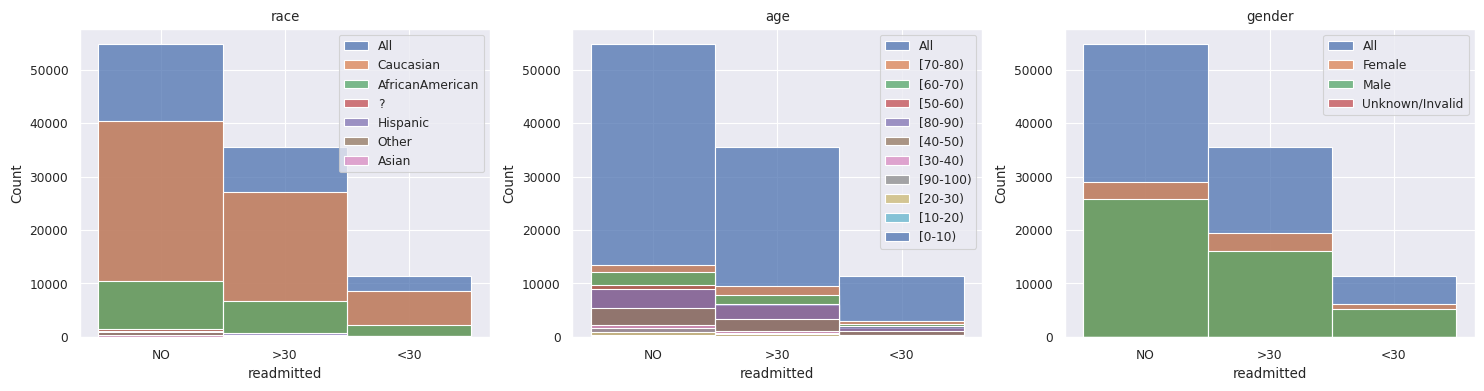

In [4]:
target_attribute = "readmitted"
sensitive_attributes = ["race", "age", "gender"]

# Set the seaborn style
fl.plot.use_style()

# Plot the distributions
fl.plot.mult_distr_plot(data, target_attribute, sensitive_attributes)
plt.show()

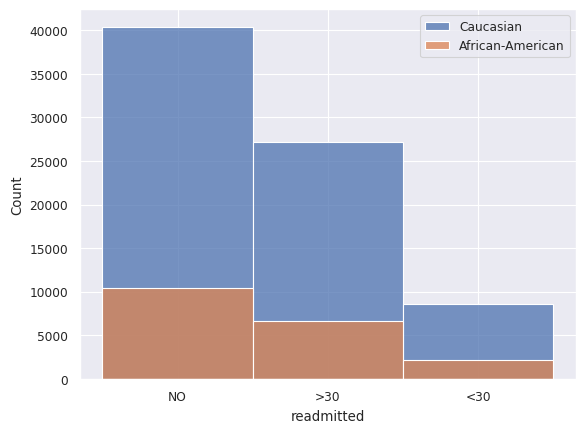

In [8]:
# Plot the distributions of decile scores in subgroups made of African-Americans and Caucasians
group1 = {"race": ["AfricanAmerican"]}
group2 = {"race": ["Caucasian"]}

fl.plot.distr_plot(data, "readmitted", [group2, group1])
plt.legend(["African-American", "Caucasian"][::-1])
plt.show()

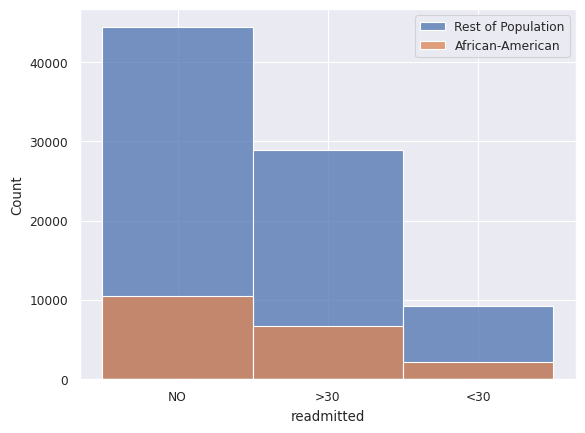

In [14]:
group1 = {"race": ["AfricanAmerican"]}
group2 = data["race"] != "AfricanAmerican"

fl.plot.distr_plot(data, "readmitted", [group2, group1])
plt.legend(["African-American", "Rest of Population"][::-1])
plt.show()

In [16]:
import fairlens.metrics as fm

group1 = {"race": ["AfricanAmerican"]}
group2 = {"race": ["Caucasian"]}

distances = {}
for metric in ["emd", "norm", "hellinger"]:
    distances[metric] = fm.stat_distance(data, "readmitted", group1, group2, mode=metric)


pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
emd,0.011813
norm,0.016219
hellinger,0.008770


In [18]:
fscorer = fl.FairnessScorer(data, "readmitted", ["gender", "race", "age"])
fscorer.distribution_score(max_comb=1, p_value=True)

,Group,Distance,Proportion,Counts,P-Value
0,[0-10),0.280757,0.001582,161,0.45
1,[10-20),0.078826,0.006790,691,0.53
2,[20-30),0.041497,0.016282,1657,0.52
3,[30-40),0.034845,0.037095,3775,0.57
4,[40-50),0.016379,0.095169,9685,0.59
5,[50-60),0.021323,0.169565,17256,0.50
6,[60-70),0.001961,0.220928,22483,0.84
7,[70-80),0.020322,0.256156,26068,0.48
8,[80-90),0.021820,0.168986,17197,0.45
9,[90-100),0.060594,0.027445,2793,0.60


In [20]:
fscorer = fl.FairnessScorer(data, "insulin", ["gender", "race", "age"])
fscorer.distribution_score(max_comb=1, p_value=True)

,Group,Distance,Proportion,Counts,P-Value
0,[0-10),0.324797,0.001582,161,0.61
1,[10-20),0.306418,0.006790,691,0.56
2,[20-30),0.209902,0.016282,1657,0.53
3,[30-40),0.081592,0.037095,3775,0.59
4,[40-50),0.050210,0.095169,9685,0.45
5,[50-60),0.019374,0.169565,17256,0.59
6,[60-70),0.004961,0.220928,22483,0.68
7,[70-80),0.030671,0.256156,26068,0.51
8,[80-90),0.037620,0.168986,17197,0.52
9,[90-100),0.053906,0.027445,2793,0.37


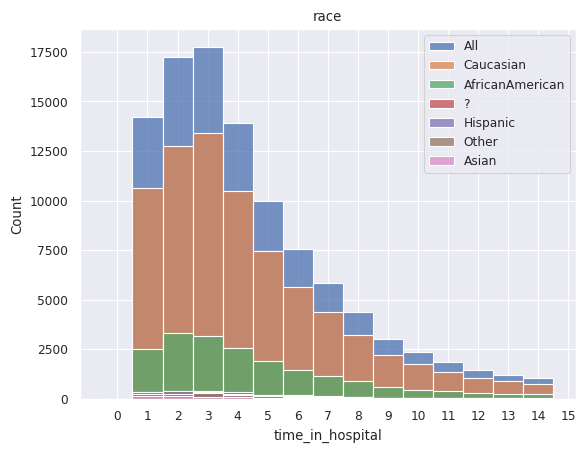

In [24]:
fl.plot.attr_distr_plot(data,"time_in_hospital", "race")
plt.show()

In [32]:
data.readmitted.sample()

99520    <30
Name: readmitted, dtype: object

In [34]:
df=data[['race', 'gender', 'age',  'time_in_hospital',
       'num_medications', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'change','insulin',
       'diabetesMed', 'readmitted']]

In [8]:
df['admitted']=df.readmitted.apply(lambda x:int(x!='NO'))

In [9]:
df.drop('readmitted', axis=1, inplace=True)

In [37]:
df=df[df.gender != 'Unknown/Invalid']

In [10]:
df

,race,gender,age,admission_type_id,time_in_hospital,num_medications,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,change,diabetesMed,admitted
0,Caucasian,Female,0,6,1,1,41,0,0,0,0,No,No,0
1,Caucasian,Female,1,1,3,18,59,0,0,0,0,Ch,Yes,1
2,AfricanAmerican,Female,2,1,2,13,11,5,2,0,1,No,Yes,0
3,Caucasian,Male,3,1,2,16,44,1,0,0,0,Ch,Yes,0
4,Caucasian,Male,4,1,1,8,51,0,0,0,0,Ch,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,7,1,3,16,51,0,0,0,0,Ch,Yes,1
101762,AfricanAmerican,Female,8,1,5,18,33,3,0,0,1,No,Yes,0
101763,Caucasian,Male,7,1,1,9,53,0,1,0,0,Ch,Yes,0
101764,Caucasian,Female,8,2,10,21,45,2,0,0,1,Ch,Yes,0


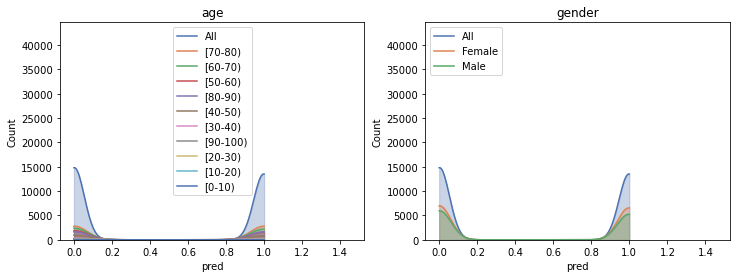

In [40]:
# Split the dataset into train and test
sp = int(len(df) * 0.8)
df_train = df[:sp].reset_index(drop=True)
df_test = df[sp:].reset_index(drop=True)

# Convert categorical columns to numerical columns
def preprocess(df):
    X = df.copy()
    X["gender"] = pd.factorize(df["gender"])[0]
    X["race"] = pd.factorize(df["race"])[0]
    X["age"].replace(X.age.unique(), range(X.age.nunique()), inplace=True)
    X["change"] = pd.factorize(df["change"])[0]
    X["insulin"] = pd.factorize(df["insulin"])[0]
    X["diabetesMed"] = pd.factorize(df["diabetesMed"])[0]
    
    X = X.to_numpy()

    y = pd.factorize(df["admitted"])[0]
    return X, y
df_train = df[:sp].reset_index(drop=True)

# Train a regressor
X, y = preprocess(df_train)
clf = RandomForestClassifier().fit(X, y)

# Classify the training data
df_train["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", [ "gender", "age"])
fscorer.plot_distributions()
plt.show()

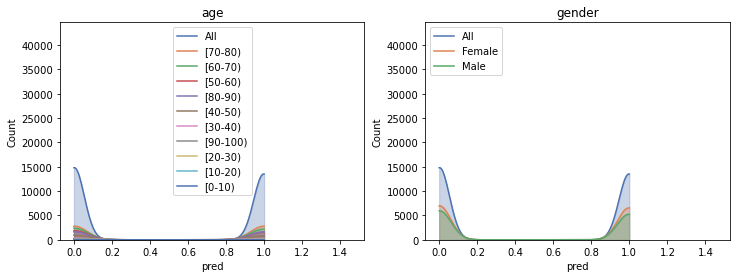

In [41]:
fscorer = fl.FairnessScorer(df_train, "pred", [ "gender", "age"])
fscorer.plot_distributions()
plt.show()

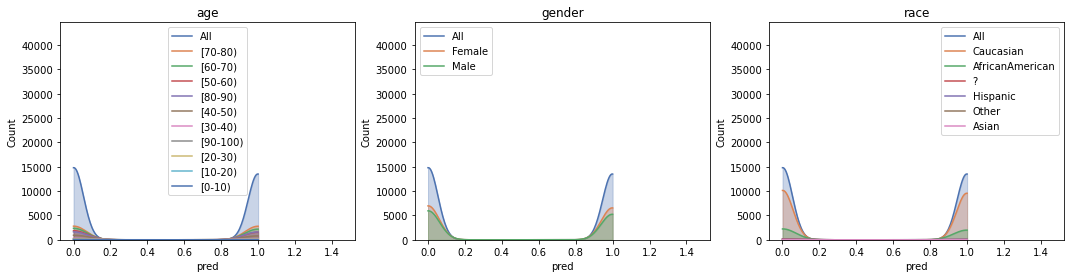

In [42]:
df_train = df[:sp].reset_index(drop=True)

# Train a regressor
X, y = preprocess(df_train)
clf = RandomForestClassifier().fit(X, y)

# Classify the training data
df_train["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["race", "gender", "age"])
fscorer.plot_distributions()
plt.show()

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
df.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [1]:
# measuring fairness
from fairlearn.metrics import (
    count,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    MetricFrame,
    make_derived_metric,
    selection_rate,  
)
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

In [15]:
mf = MetricFrame(
    metrics={"selection rate (COMPAS)": selection_rate},
    y_true=data["readmitted"],  # is ignored
    y_pred=data["readmitted"]!='NO',
    sensitive_features=data["race"],
)

# print results
display(mf.by_group)
print("Overall selection rate: %.2f" % mf.overall)

# compute demographic parity as the max difference between groups
print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

,selection rate (COMPAS)
race,
?,0.319402
AfricanAmerican,0.457522
Asian,0.352574
Caucasian,0.469336
Hispanic,0.419244
Other,0.39243


Overall selection rate: 0.46
demographic parity difference: 0.15


In [24]:
# compute metrics
mf = MetricFrame(
    metrics={"selection rate (COMPAS)": selection_rate},
    y_true=data["readmitted"],  # is ignored
    y_pred=data["readmitted"]!='NO',
    sensitive_features=data["race"],
)

# print results
display(mf.by_group)

# print differences
for i in mf.difference("between_groups").iteritems():
    print("%s diff: %.2f" % i)

# alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(
    data["readmitted"],
    data["readmitted"]!='NO',
    sensitive_features=data["race"],
    method="between_groups",
)
print("equalized odds diff: %.2f" % dpd)

,selection rate (COMPAS)
race,
?,0.319402
AfricanAmerican,0.457522
Asian,0.352574
Caucasian,0.469336
Hispanic,0.419244
Other,0.39243


selection rate (COMPAS) diff: 0.15


TypeError: '<' not supported between instances of 'bool' and 'str'

In [25]:
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from IPython.display import Markdown, display

In [10]:
from  pycaret.classification import *

In [11]:
df

,race,gender,age,admission_type_id,time_in_hospital,num_medications,num_lab_procedures,num_procedures,number_outpatient,number_emergency,number_inpatient,change,diabetesMed,readmitted
0,Caucasian,Female,0,6,1,1,41,0,0,0,0,No,No,NO
1,Caucasian,Female,1,1,3,18,59,0,0,0,0,Ch,Yes,>30
2,AfricanAmerican,Female,2,1,2,13,11,5,2,0,1,No,Yes,NO
3,Caucasian,Male,3,1,2,16,44,1,0,0,0,Ch,Yes,NO
4,Caucasian,Male,4,1,1,8,51,0,0,0,0,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,7,1,3,16,51,0,0,0,0,Ch,Yes,>30
101762,AfricanAmerican,Female,8,1,5,18,33,3,0,0,1,No,Yes,NO
101763,Caucasian,Male,7,1,1,9,53,0,1,0,0,Ch,Yes,NO
101764,Caucasian,Female,8,2,10,21,45,2,0,0,1,Ch,Yes,NO


In [13]:
s=setup(df, target='readmitted')

,Description,Value
0,session_id,6515
1,Target,readmitted
2,Target Type,Multiclass
3,Label Encoded,"<30: 0, >30: 1, NO: 2"
4,Original Data,"(99492, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
lightgbm= create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5707,0.6398,0.3932,0.5315,0.5140,0.1523,0.1704
1,0.5770,0.6483,0.3991,0.5504,0.5206,0.1651,0.1846
2,0.5783,0.6509,0.3996,0.5392,0.5224,0.1678,0.1875
3,0.5622,0.6382,0.3868,0.5342,0.5048,0.1346,0.1511
4,0.5747,0.6422,0.3984,0.5457,0.5195,0.1615,0.1800
5,0.5821,0.6485,0.4009,0.5459,0.5237,0.1716,0.1944
6,0.5706,0.6458,0.3959,0.5414,0.5158,0.1543,0.1717
7,0.5814,0.6533,0.4038,0.5596,0.5259,0.1730,0.1942
8,0.5669,0.6394,0.3901,0.5218,0.5094,0.1444,0.1622


,Samples,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,Selection Rate
race,,,,,,,,,
AfricanAmerican,5665,0.628244,0.615889,0.491572,0.607853,0.543563,0.235856,0.239643,0.364166
Asian,186,0.693548,0.604839,0.33871,0.567568,0.424242,0.233184,0.247608,0.198925
Caucasian,22971,0.620304,0.613116,0.487165,0.624822,0.547473,0.228955,0.234224,0.367594
Hispanic,602,0.67608,0.643304,0.491525,0.60733,0.543326,0.296653,0.30064,0.317276
Other,424,0.615566,0.559951,0.309091,0.51,0.384906,0.129133,0.137703,0.235849


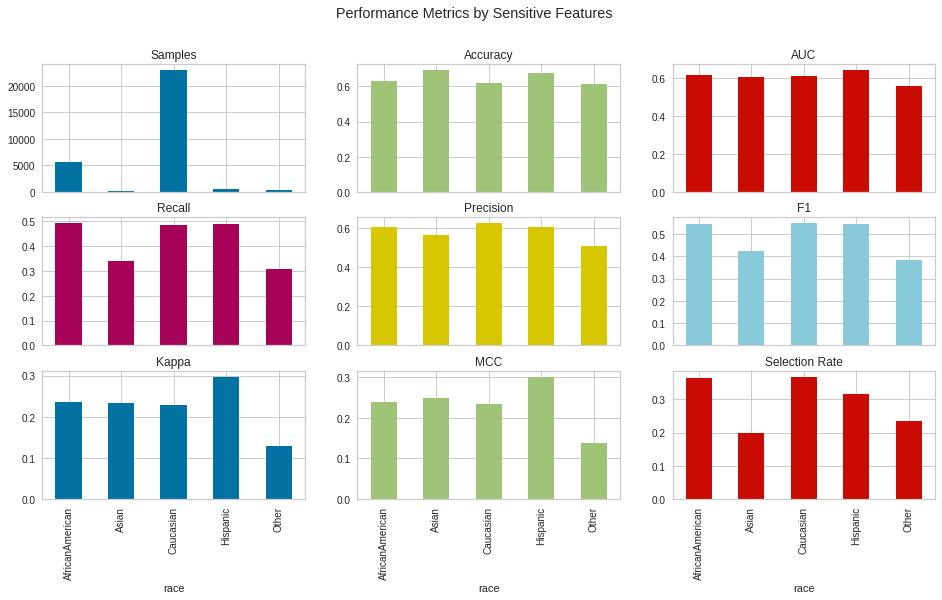

In [17]:
check_fairness(lightgbm,['race'] )

,Samples,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,Selection Rate
age,,,,,,,,,
0,46,0.869565,0.571429,0.142857,1.0,0.25,0.220339,0.351866,0.021739
1,212,0.707547,0.644064,0.457143,0.571429,0.507937,0.303518,0.307343,0.264151
2,504,0.742063,0.734948,0.622881,0.781915,0.693396,0.475672,0.484845,0.373016
3,1099,0.67061,0.654855,0.518519,0.663158,0.581986,0.316869,0.323405,0.345769
4,2841,0.668779,0.652663,0.5184,0.656535,0.579347,0.31237,0.318303,0.347413
5,5119,0.648173,0.629822,0.477566,0.632353,0.544166,0.266665,0.273641,0.332096
6,6521,0.627051,0.619362,0.47891,0.641182,0.548291,0.241901,0.249385,0.353013
7,7671,0.596532,0.592167,0.485862,0.597459,0.535912,0.185702,0.188812,0.38991
8,5054,0.584685,0.582892,0.495758,0.590472,0.538985,0.166323,0.16843,0.411159


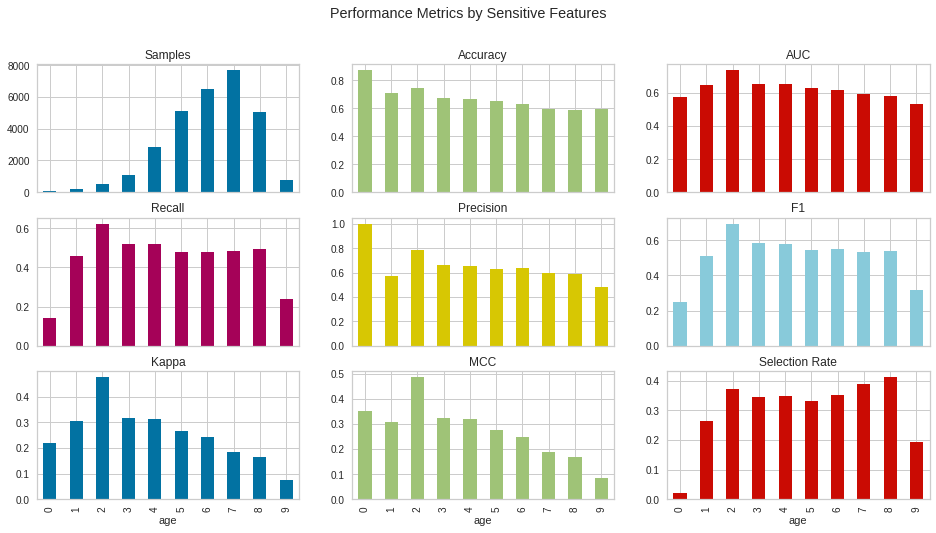

In [18]:
check_fairness(lightgbm,['age'] )